In [1]:
%load_ext autoreload
%autoreload 2

from src import GP_kernels as gpk
from jax.random import PRNGKey, split
from jax import numpy as jnp
import equinox as eqx
from numpyro.handlers import trace, substitute
from experiments.bayesian_reg.bayesian_regression import bayesian_linear_regression, analytical_mean, analytical_covariance, plot_posterior, get_contours
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal, norm
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

from src.utils.trace_dataset import load_traces
from jax.tree_util import tree_map
from src.utils.miscellaneous import dict_to_namedtuple
from src.diffusion_head import DiffusionHead, DiffusionConf
from src.gaussian_mixture_head import GaussianMixture, GaussianMixtureCfg
from src.InferenceModel import InferenceModel, InferenceModelCfg
from src.real_nvp import RealNVP_Flow, RealNVPConfig


In [2]:
variable_metadata = load_traces("experiments/bayesian_regression/data/metadata.pkl")
variable_metadata = tree_map(lambda x: jnp.array(x, dtype=np.float32), variable_metadata)
variable_metadata = dict_to_namedtuple(variable_metadata)
eval_traces = load_traces("experiments/bayesian_reg/data/test_1MM.pkl")

continuous_distribution = DiffusionHead(
  c=DiffusionConf(
    num_latents=1,
    width_size=512,
    depth=8,
    num_conds=128,
    num_steps=100,
    noise_scale=0.008,
    dropout_rate=0.1,
    use_normalizer=False,
  ),
  key=PRNGKey(13),
)
# continuous_distribution = RealNVP_Flow(
#   c = RealNVPConfig(
#     num_latents=1,
#     num_blocks=8,
#     num_layers_per_block=2,
#     block_hidden_size=256,
#     num_conds=128,
#     normalizer_width=512,
#   ),
#   key=PRNGKey(13),
# )
# gmc = GaussianMixtureCfg(
#   resnet_mlp_width=512,
#   d_model=256,
#   num_mlp_blocks=3,
#   num_mixtures=3,
#   dropout_rate=0.0,
# )

# continuous_distribution = GaussianMixture(c=gmc, key=PRNGKey(13))

inference = InferenceModel(
    key=PRNGKey(0),
    c=InferenceModelCfg(
        variable_metadata=variable_metadata,
        d_model = 128,
        dropout_rate = 0.0,
        discrete_mlp_width = 512,
        discrete_mlp_depth=1,
        num_enc_layers=4,
        max_discrete_choices =6,
        num_input_variables = (1,),
        num_observations =6,
      ),
    continuous_distribution=continuous_distribution
    )


In [3]:
inference = eqx.tree_deserialise_leaves("tmp/blr_diff_drop0.0_no_norm_best.eqx", inference)
inference = eqx.tree_inference(inference, True)


In [4]:
sampler_ = lambda key: bayesian_linear_regression(key, 0.1, 10.0, jnp.arange(6.0)+1)
seed = PRNGKey(888434587)
tr = trace(sampler_).get_trace(key=seed)
obs = tr['obs']['value']
tr

OrderedDict([('x1',
              {'type': 'sample',
               'name': 'x1',
               'fn': <numpyro.distributions.continuous.Normal at 0x7f0fb4089310>,
               'args': (),
               'kwargs': {'rng_key': Array([3718023120, 2344842080], dtype=uint32),
                'sample_shape': ()},
               'value': Array(-2.4304032, dtype=float32),
               'scale': None,
               'is_observed': False,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('x2',
              {'type': 'sample',
               'name': 'x2',
               'fn': <numpyro.distributions.continuous.Normal at 0x7f100c092b80>,
               'args': (),
               'kwargs': {'rng_key': Array([1386582471, 3768030610], dtype=uint32),
                'sample_shape': ()},
               'value': Array(-1.651469, dtype=float32),
               'scale': None,
               'is_observed': False,
               'interm

In [5]:
from collections import OrderedDict

from jax import jit, vmap


# samples = [inference.rsample(obs,sampler_,PRNGKey(i+7777843))[0] for i in tqdm(range(500))]
tr_ = OrderedDict({k: v['value'].dtype in (jnp.int32,) for k,v in tr.items()})
fn = jit(lambda k: inference.rsample_static(obs, tr_, k))
samples, _, all_log_p = vmap(fn)(split(PRNGKey(0), 1000))


x1 init
x1 False
x2 init
x2 False
obs init
obs False


In [6]:
sigma = 0.1
alpha = 10.0
mu = analytical_mean(jnp.arange(6.0)+1, obs.reshape(-1), sigma, alpha)
cov = analytical_covariance(jnp.arange(6.0)+1, sigma, alpha)
mu, cov, obs

(array([-1.67259387, -2.42519115]),
 array([[ 0.00866588, -0.00199982],
        [-0.00199982,  0.00057139]]),
 Array([[ -4.037077 ],
        [ -6.6730466],
        [ -8.766282 ],
        [-11.576265 ],
        [-13.642409 ],
        [-16.269663 ]], dtype=float32))

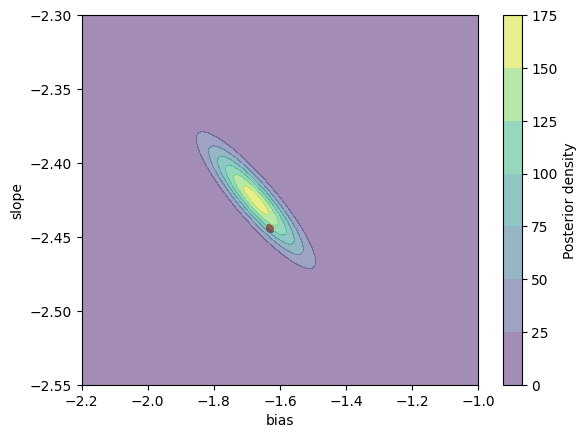

In [9]:
from matplotlib import pyplot as plt
plot_posterior(plt, mu, cov, samples, set_limits=True)